In [1]:
using Pkg

Pkg.activate(mktempdir())
Pkg.update()

Pkg.add([
    "LinearAlgebra"
    "CairoMakie"
    "Statistics"
    "Random"
])


  Activating new project at `C:\Users\79021\AppData\Local\Temp\jl_hPryKI`
    Updating registry at `C:\Users\79021\.julia\registries\General.toml`
     Project No packages added to or removed from `C:\Users\79021\AppData\Local\Temp\jl_hPryKI\Project.toml`
    Manifest No packages added to or removed from `C:\Users\79021\AppData\Local\Temp\jl_hPryKI\Manifest.toml`
   Resolving package versions...
    Updating `C:\Users\79021\AppData\Local\Temp\jl_hPryKI\Project.toml`
  [13f3f980] + CairoMakie v0.15.8
  [10745b16] + Statistics v1.11.1
  [37e2e46d] + LinearAlgebra v1.12.0
  [9a3f8284] + Random v1.11.0
    Updating `C:\Users\79021\AppData\Local\Temp\jl_hPryKI\Manifest.toml`
  [621f4979] + AbstractFFTs v1.5.0
  [1520ce14] + AbstractTrees v0.4.5
  [79e6a3ab] + Adapt v4.4.0
  [35492f91] + AdaptivePredicates v1.2.0
  [66dad0bd] + AliasTables v1.1.3
  [27a7e980] + Animations v0.4.2
  [67c07d97] + Automa v1.1.0
  [13072b0f] + AxisAlgorithms v1.1.0
  [39de3d68] + AxisArrays v0.4.8
  [18cc8868] + 

Section 1: Scalar case
True weight: 2.5
Learned weight: 2.587195701749485


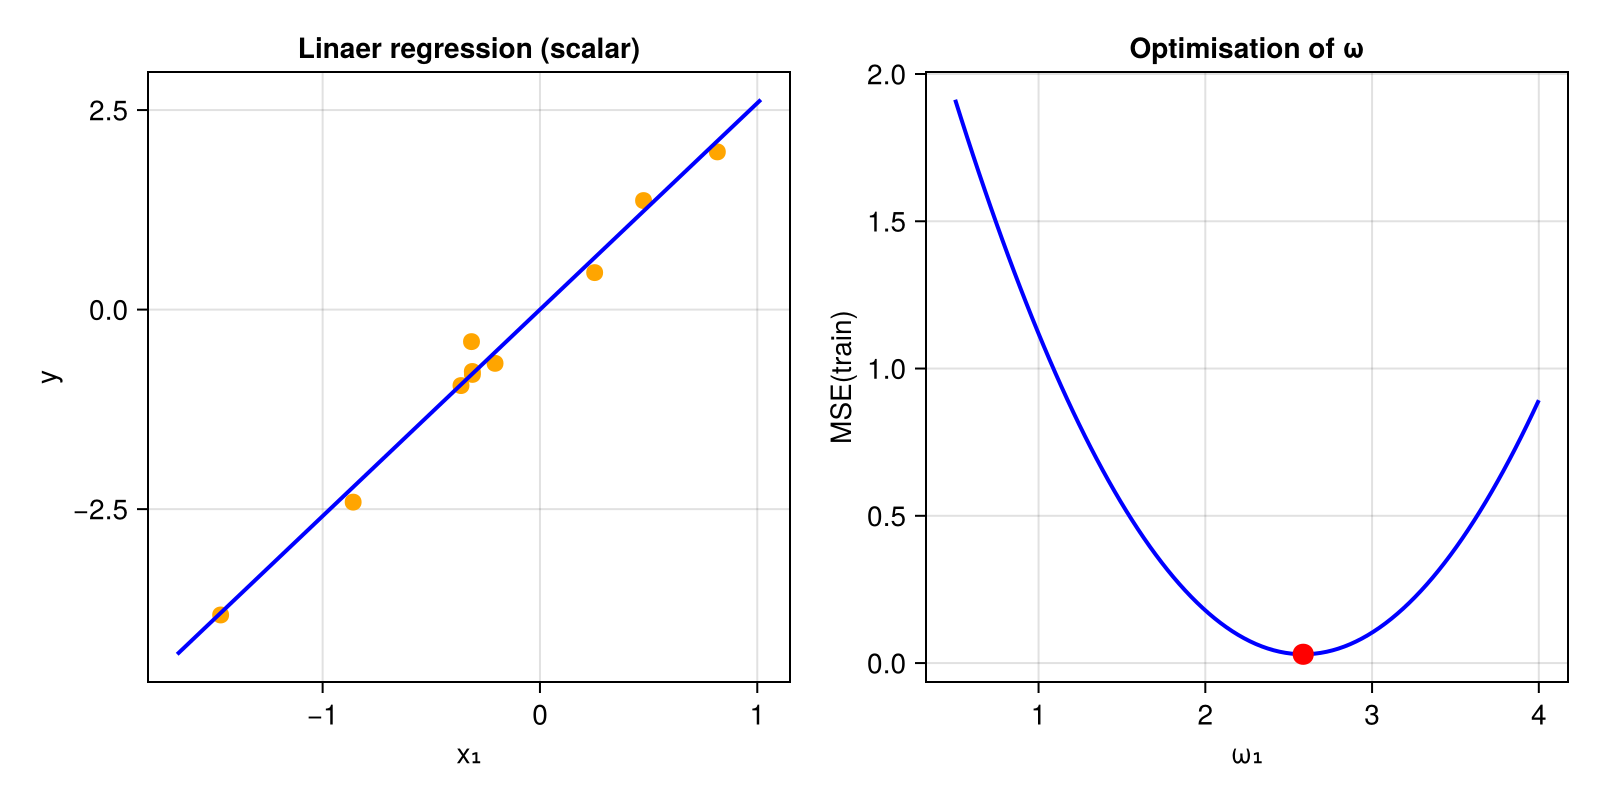

In [ ]:
# ============================================================================
# SECTION 1: SCALAR CASE (Single Feature)
# ============================================================================
# Model: ŷ = w₁x  (no bias, matching Figure 5.1)
#
# DERIVATION:
# MSE = (1/m) Σᵢ (ŷᵢ - yᵢ)² = (1/m) Σᵢ (w₁xᵢ - yᵢ)²
#
# To minimize, set ∂MSE/∂w₁ = 0:
# ∂MSE/∂w₁ = (2/m) Σᵢ (w₁xᵢ - yᵢ)xᵢ = 0
# Σᵢ w₁xᵢ² = Σᵢ xᵢyᵢ
# w₁ = Σᵢ xᵢyᵢ / Σᵢ xᵢ²
# ============================================================================

using CairoMakie
using LinearAlgebra
using Statistics
using Random

Random.seed!(42)

m_scalar = 10
x_scalar = randn(m_scalar)
w_true_scalar = 2.5
y_scalar = w_true_scalar .* x_scalar .+ 0.3 .* randn(m_scalar)

w_optimal_scalar = sum(x_scalar .* y_scalar) / sum(x_scalar.^2)

println("Section 1: Scalar case")
println("True weight: $w_true_scalar")
println("Learned weight: $w_optimal_scalar")

x_line = range(minimum(x_scalar) - 0.2, maximum(x_scalar) + 0.2, length=100)
y_line = w_optimal_scalar .* x_line

fig1 = Figure(size=(800, 400))

ax1a = Axis(fig1[1, 1], xlabel="x₁", ylabel="y", title = "Linaer regression (scalar)")
scatter!(ax1a, x_scalar, y_scalar, markersize=12, color=:orange)
lines!(ax1a, collect(x_line), collect(y_line), color=:blue, linewidth=2)

w_range = range(0.5, 4.0, length=100)
mse_values = [mean((w .* x_scalar .- y_scalar).^2) for w in w_range]

ax1b = Axis(fig1[1, 2], xlabel="ω₁", ylabel="MSE(train)", 
title="Optimisation of ω")
lines!(ax1b, collect(w_range), mse_values, color=:blue, linewidth=2)
scatter!(ax1b, [w_optimal_scalar], [mean((w_optimal_scalar .* x_scalar .- y_scalar).^2)],
markersize=15, color=:red)

fig1

In [11]:
# ============================================================================
# SECTION 2: VECTOR CASE (Multiple Features)
# ============================================================================
# Model: ŷ = Xw  where X ∈ ℝ^(m×n), w ∈ ℝⁿ
#
# MATRIX DERIVATION:
# MSE = (1/m) ‖Xw - y‖²₂ = (1/m)(Xw - y)ᵀ(Xw - y)
#
# Expanding:
# MSE = (1/m)(wᵀXᵀXw - 2wᵀXᵀy + yᵀy)
#
# Gradient (using ∂(wᵀAw)/∂w = 2Aw for symmetric A):
# ∇ᵥMSE = (2/m)(XᵀXw - Xᵀy)
#
# Setting ∇ᵥMSE = 0:
# XᵀXw = Xᵀy
# w = (XᵀX)⁻¹Xᵀy  ← NORMAL EQUATIONS
# ============================================================================

using CairoMakie
using LinearAlgebra
using Statistics
using Random

Random.seed!(42)

m_vector = 100
n_features = 3

X_vector = randn(m_vector, n_features)
w_true_vector = [1.5, -2.0, 0.8]
y_vector = X_vector * w_true_vector .+ 0.2 .* randn(m_vector)

w_normal = (X_vector' * X_vector) \ (X_vector' * y_vector)

println("\nSection 2: vector case")
println("True weights: $w_true_vector")
println("Learned weights: $w_normal")

y_pred_vector = X_vector * w_normal
mse_vector = mean((y_pred_vector .- y_vector).^2)
println("Training MSE: $mse_vector")


Section 2: vector case
True weights: [1.5, -2.0, 0.8]
Learned weights: [1.5242715803472398, -1.977793032782363, 0.7480560242351249]
Training MSE: 0.032500975663225115


In [12]:
# ============================================================================
# SECTION 3: WITH BIAS TERM
# ============================================================================
# Model: ŷ = wᵀx + b  (affine transformation)
#
# TRICK: Augment x with constant 1
# x̃ = [x; 1], w̃ = [w; b]
# Then: ŷ = w̃ᵀx̃ reduces to standard form
#
# Implementation: add column of ones to X
# X̃ = [X | 1]  where 1 is column vector of ones
# ============================================================================

using CairoMakie
using LinearAlgebra
using Statistics
using Random

X_augmented = hcat(X_vector, ones(m_vector))
w_with_bias = (X_augmented' * X_augmented) \ (X_augmented' * y_vector)

println("\nSection 3: with bias")
println("Weights: $(w_with_bias[1:end-1])")
println("Bias: $(w_with_bias[end])")


Section 3: with bias
Weights: [1.5235577374335136, -1.977785464408734, 0.745995185275224]
Bias: -0.011061983667958165



Section 4: Gradient descent
GD weights: [1.5235577374335143, -1.9777854644087323, 0.7459951852752227]
GD bias: -0.011061983667958417
Final MSE: 0.03238309626179678


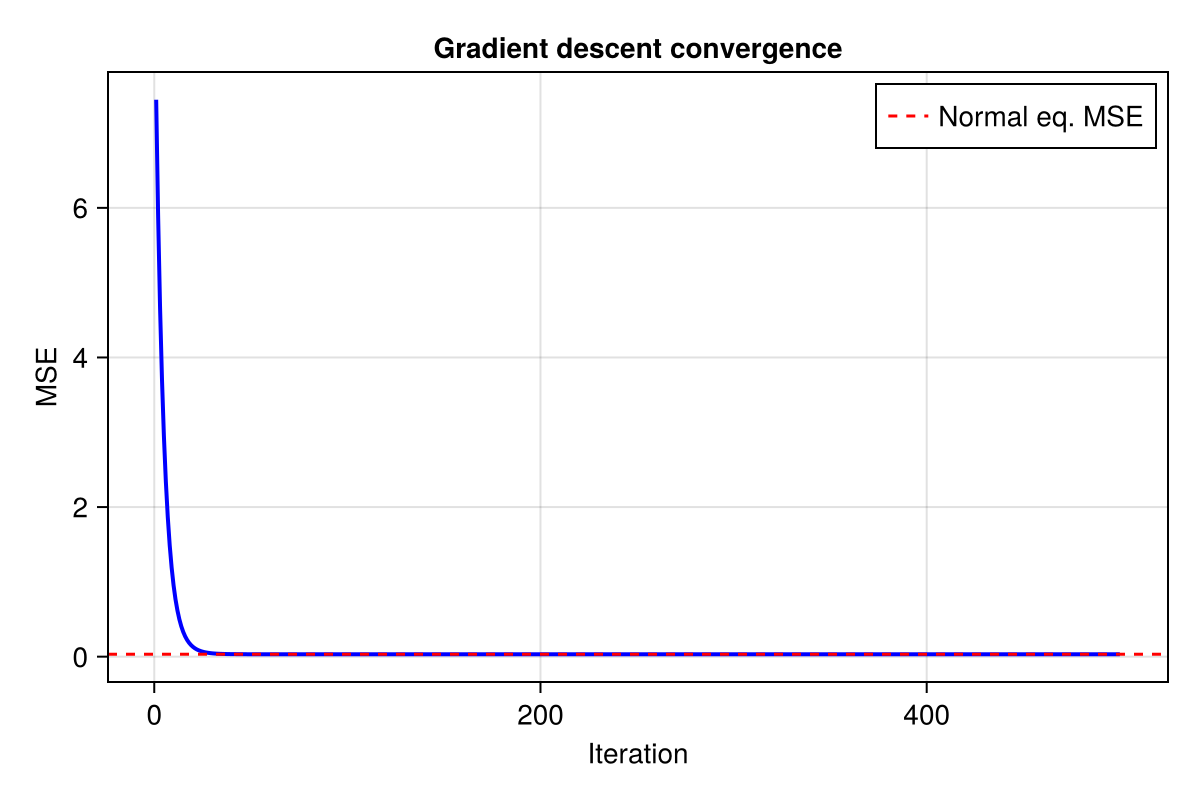

In [14]:
# ============================================================================
# SECTION 4: GRADIENT DESCENT
# ============================================================================
# Instead of closed-form, iteratively update:
# w ← w - α∇ᵥMSE
# w ← w - α(2/m)Xᵀ(Xw - y)
#
# Simplify (absorb 2 into learning rate):
# w ← w - (α/m)Xᵀ(Xw - y)
# ============================================================================

using LinearAlgebra
using CairoMakie
using Statistics
using Random

function gradient_descent(X, y; α=0.01, iterations=1000)
    m, n = size(X)
    w = zeros(n)
    history = Float64[]

    for I in 1:iterations
        residual = X * w - y
        gradient = (1/m) * X' * residual
        w = w - α * gradient
        push!(history, mean(residual.^2))
    end

    return w, history
end

w_gd, loss_history = gradient_descent(X_augmented, y_vector, α=0.1, iterations=500)

println("\nSection 4: Gradient descent")
println("GD weights: $(w_gd[1:end-1])")
println("GD bias: $(w_gd[end])")
println("Final MSE: $(loss_history[end])")

fig2 = Figure(size=(600, 400))
ax2 = Axis(fig2[1,1], xlabel="Iteration", ylabel="MSE", title="Gradient descent convergence")
lines!(ax2, 1:length(loss_history), loss_history, color=:blue, linewidth=2)
hlines!(ax2, [mse_vector], color=:red, linestyle=:dash, label="Normal eq. MSE")
axislegend(ax2)
fig2


Section 5: ridge regression (λ=0.01)
Ridge weights: [1.5114377672520296, -1.9588204908766331, 0.7368987957393297]
Ridge bias: -0.013374646162737968


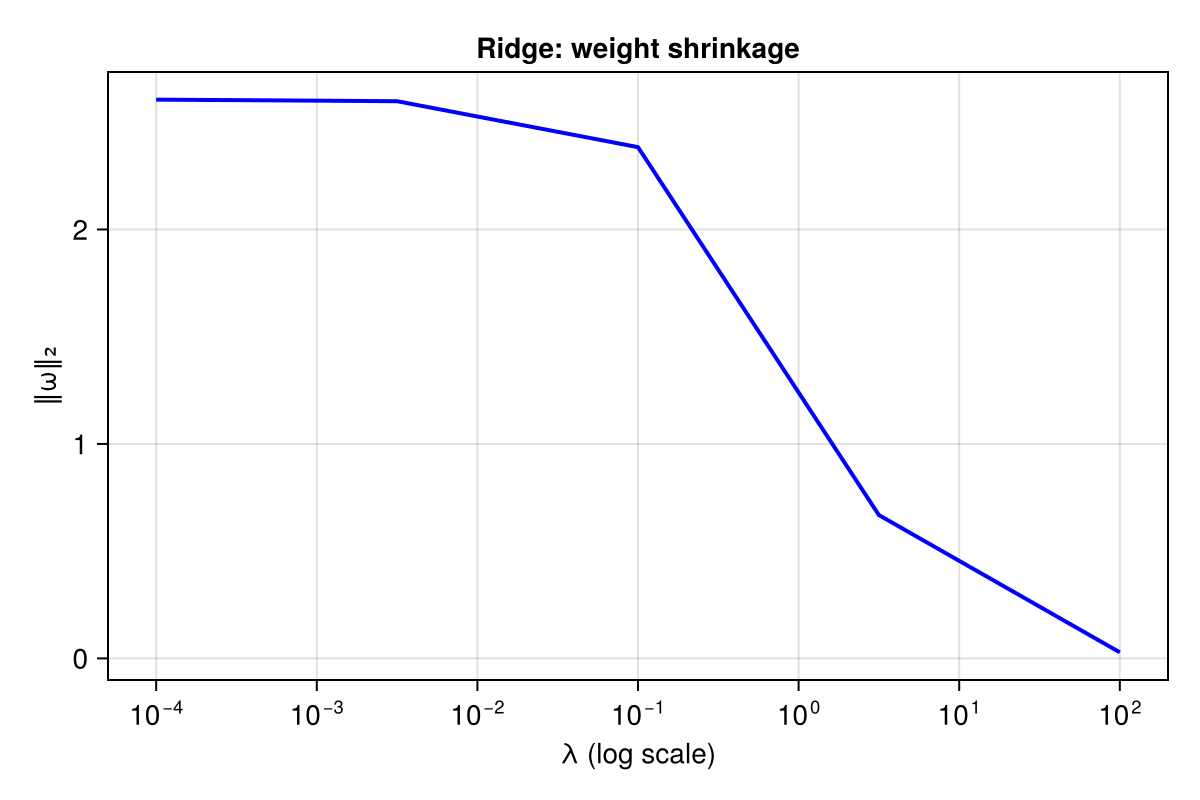

In [15]:
# ============================================================================
# SECTION 5: REGULARISATION (Ridge / L2)
# ============================================================================
# Problem: (XᵀX) may be singular or ill-conditioned
# Solution: Add penalty λ‖w‖²₂ to loss
#
# Loss = (1/m)‖Xw - y‖²₂ + λ‖w‖²₂
#
# DERIVATION:
# ∇ᵥLoss = (2/m)Xᵀ(Xw - y) + 2λw = 0
# XᵀXw + mλw = Xᵀy
# (XᵀX + mλI)w = Xᵀy
# w = (XᵀX + mλI)⁻¹Xᵀy
#
# Note: mλI ensures (XᵀX + mλI) is always invertible
# ============================================================================

function ridge_regression(X, y; λ=0.1)
    m, n = size(X)
    return (X' * X + m * λ * I) \ (X' * y)
end

w_ridge = ridge_regression(X_augmented, y_vector, λ=0.01)

println("\nSection 5: ridge regression (λ=0.01)")
println("Ridge weights: $(w_ridge[1:end-1])")
println("Ridge bias: $(w_ridge[end])")

lambdas = 10.0 .^ range(-4, 2, length=5[])
weight_norms = [norm(ridge_regression(X_augmented, y_vector, λ=λ)[1:end-1]) for λ in lambdas]

fig3 = Figure(size=(600, 400))
ax3 = Axis(fig3[1, 1], xlabel="λ (log scale)", ylabel="∥ω∥₂",
    title="Ridge: weight shrinkage", xscale=log10)
lines!(ax3, lambdas, weight_norms, color=:blue, linewidth=2)
fig3

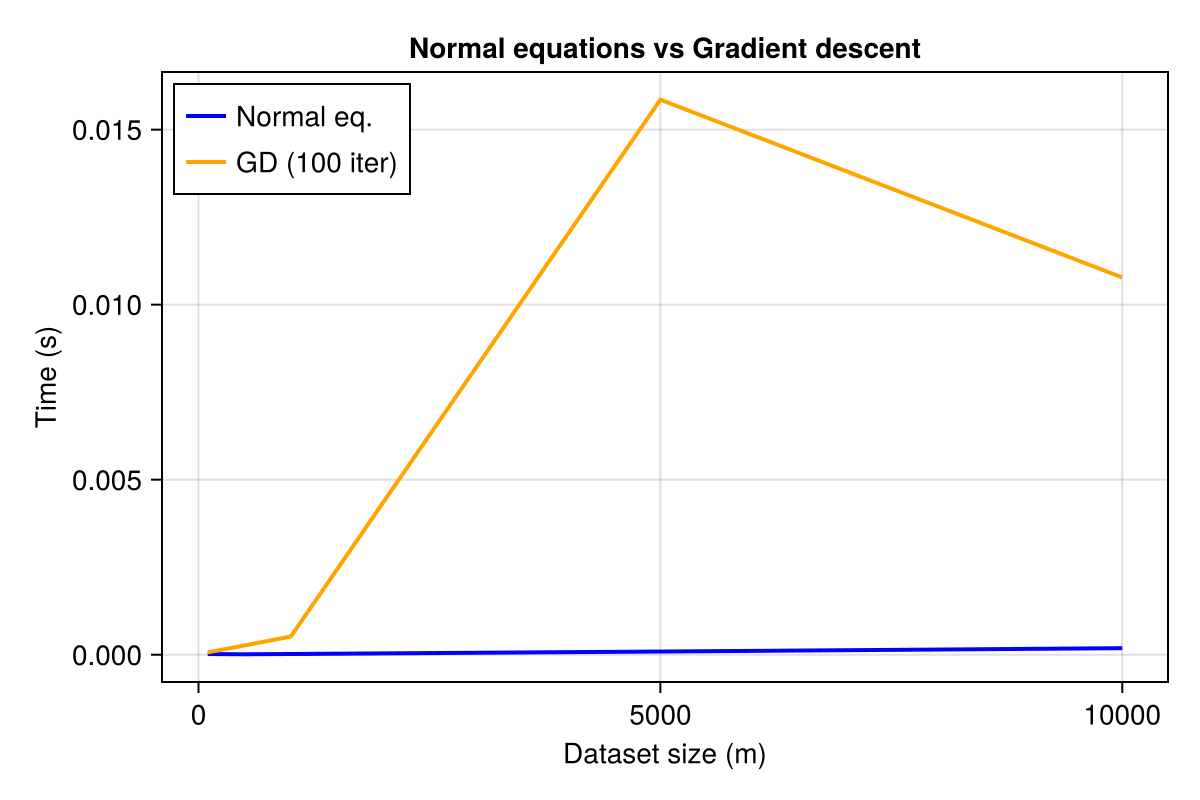

In [20]:
# ============================================================================
# SECTION 6: COMPARISON — Normal Equations vs Gradient Descent
# ============================================================================

using CairoMakie
using LinearAlgebra
using Statistics
using Random

function compare_methods(m_sizes, n_features=10)
    times_normal = Float64[]
    times_gd = Float64[]
    
    for m in m_sizes
        X = randn(m, n_features)
        X_aug = hcat(X, ones(m))
        y = randn(m)

        t_normal = @elapsed (X_aug' * X_aug) \ (X_aug' * y)
        push!(times_normal, t_normal)

        t_gd = @elapsed gradient_descent(X_aug, y, α=0.01, iterations=100)
        push!(times_gd, t_gd)
    end

    return times_normal, times_gd
end

m_sizes = [100, 500, 1000, 5000, 10000]
t_normal, t_gd = compare_methods(m_sizes)

fig4 = Figure(size=(600, 400))
ax4 = Axis(fig4[1, 1], xlabel="Dataset size (m)", ylabel="Time (s)",
    title="Normal equations vs Gradient descent")
lines!(ax4, m_sizes, t_normal, color=:blue, linewidth=2, label="Normal eq.")
lines!(ax4, m_sizes, t_gd, color=:orange, linewidth=2, label="GD (100 iter)")
axislegend(ax4, position=:lt)
fig4

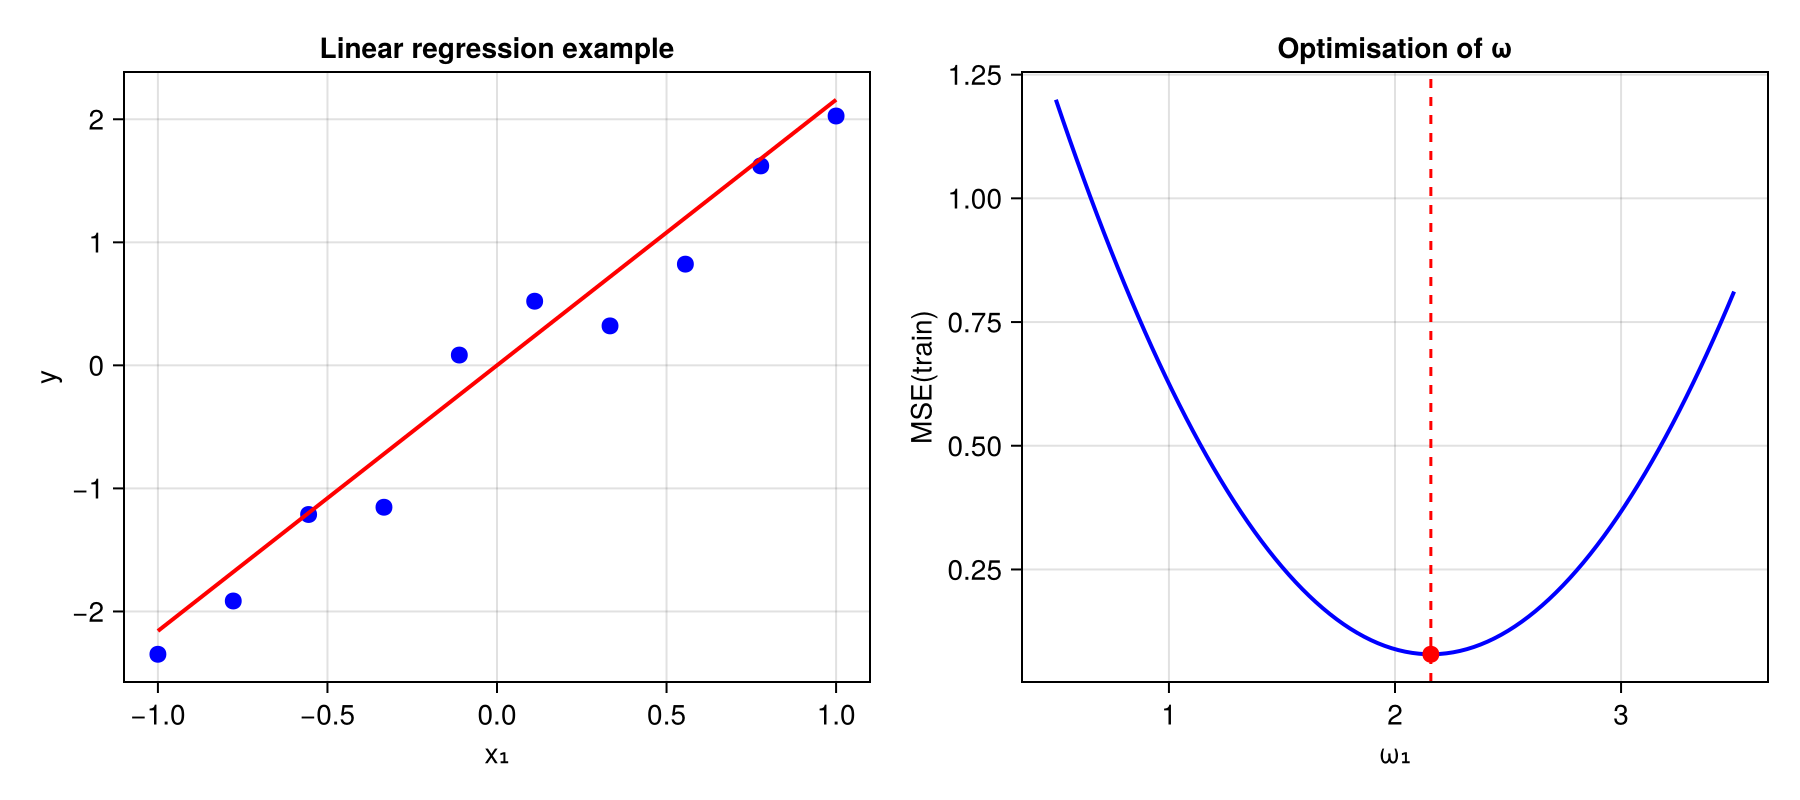

In [4]:
# ============================================================================
# SECTION 7: SYNTHETIC DATA MATCHING FIGURE 5.1
# ============================================================================

using CairoMakie
using Statistics
using LinearAlgebra

m_fig = 10
x_fig = range(-1.0, 1.0, length=m_fig) |> collect
w_fig_true = 2.0
y_fig = w_fig_true .* x_fig .+ 0.3 .* randn(m_fig)

w_fig_learned = sum(x_fig .* y_fig) / sum(x_fig.^2)

fig5 = Figure(size=(900, 400))

ax5a = Axis(fig5[1, 1], xlabel="x₁", ylabel="y", title="Linear regression example")
scatter!(ax5a, x_fig, y_fig, markersize=12, color=:blue)
x_plot = range(-1.0, 1.0, length=100)
lines!(ax5a, collect(x_plot), w_fig_learned .* collect(x_plot), color=:red, linewidth=2)

w_test = range(0.5, 3.5, length=100)
mse_test = [mean((w .* x_fig .- y_fig).^2) for w in w_test]

ax5b = Axis(fig5[1,2], xlabel="ω₁", ylabel="MSE(train)", title="Optimisation of ω")
lines!(ax5b, collect(w_test), mse_test, color=:blue, linewidth=2)
vlines!(ax5b, [w_fig_learned], color=:red, linestyle=:dash)
scatter!(ax5b, [w_fig_learned], [mean((w_fig_learned .* x_fig .- y_fig).^2)], markersize=12, color=:red)

fig5

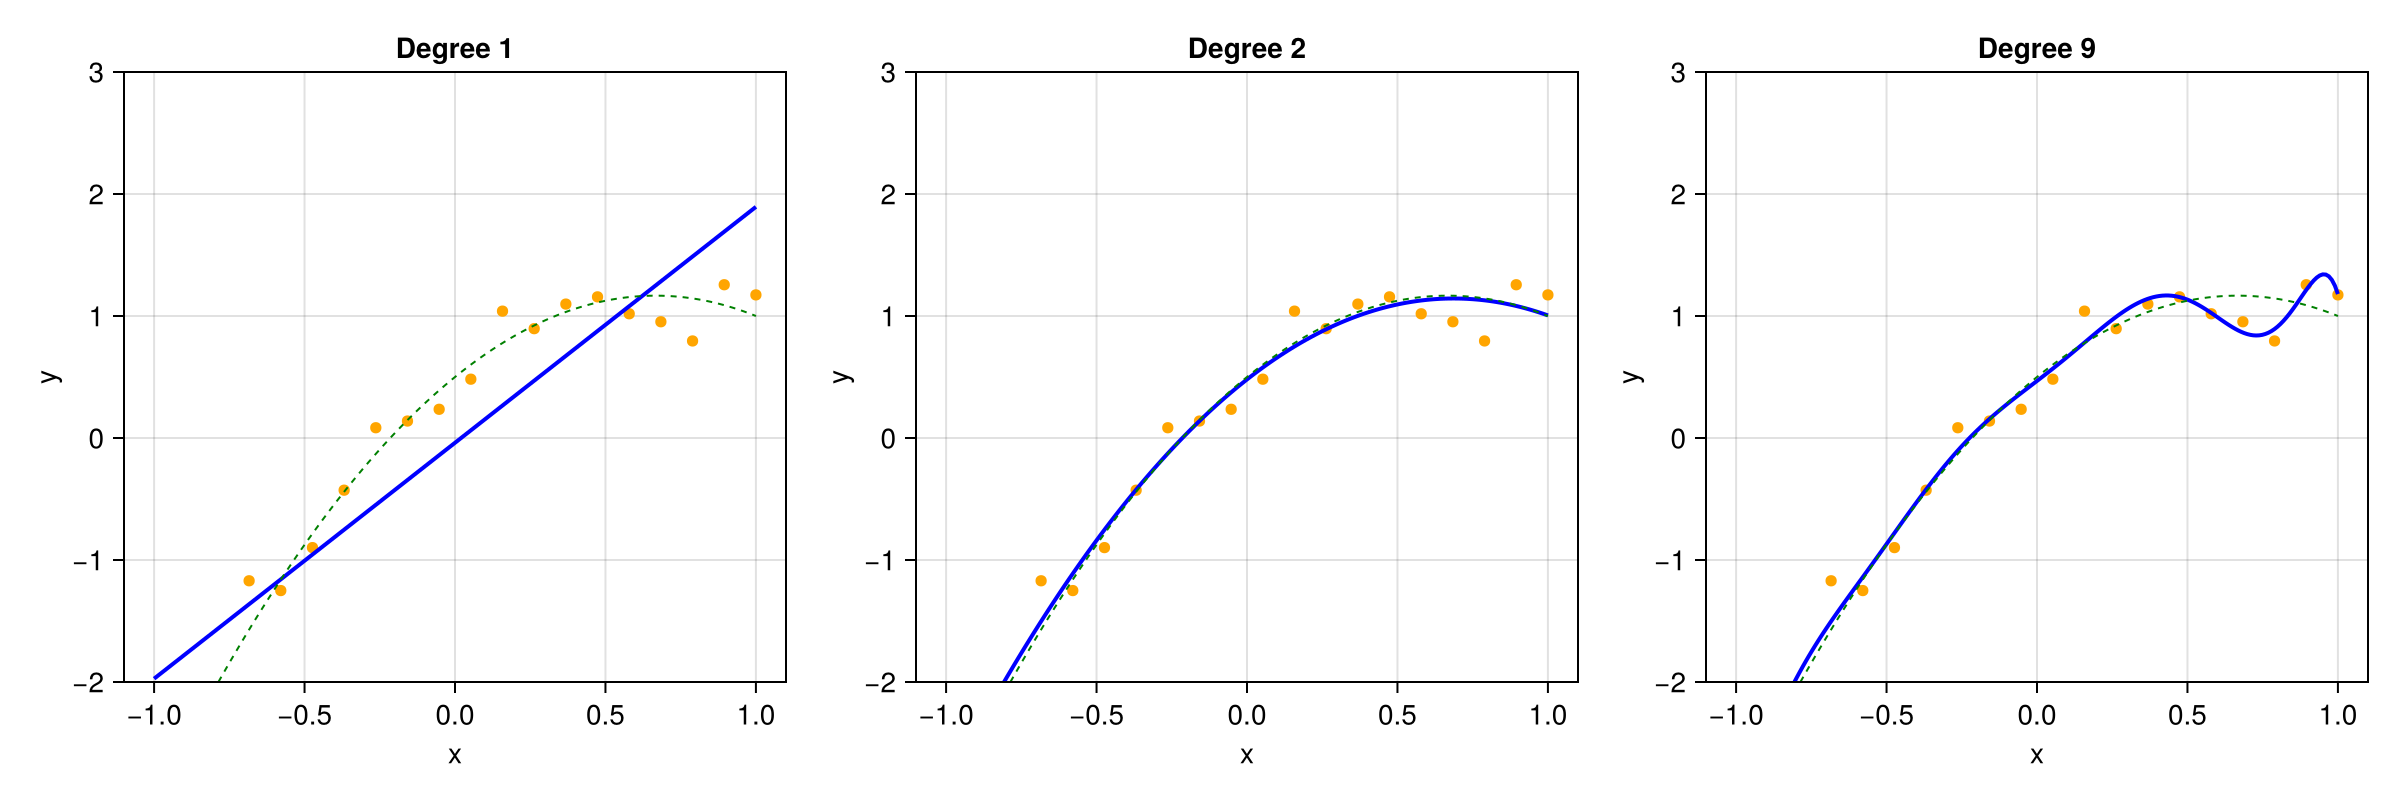

In [7]:
# ============================================================================
# SECTION 8: POLYNOMIAL EXTENSION (Eq. 5.15-5.17)
# ============================================================================
# ŷ = b + w₁x + w₂x² + ... + wₐx^d
#
# Create feature matrix: Φ = [1, x, x², ..., x^d]
# Then standard linear regression on Φ
# ============================================================================

using CairoMakie
using Statistics
using LinearAlgebra

function polynomial_features(x, degree)
    m = length(x)
    Φ = zeros(m, degree + 1)
    for d in 0:degree
        Φ[:, d+1] = x.^d
    end
    return Φ
end

x_poly = range(-1.0, 1.0, length=20) |> collect
y_poly_true = 0.5 .+ 2.0 .* x_poly .- 1.5 .* x_poly.^2
y_poly = y_poly_true .+ 0.2 .* randn(20)

fig6 = Figure(size=(1200, 400))
degrees = [1, 2 ,9]
x_dense = range(-1.0, 1.0, length=200) |> collect

for (i, d) in enumerate(degrees)
    Φ_train = polynomial_features(x_poly, d)
    w_poly = (Φ_train' * Φ_train) \ (Φ_train' * y_poly)

    Φ_plot = polynomial_features(x_dense, d)
    y_plot = Φ_plot * w_poly

    ax = Axis(fig6[1, i], xlabel="x", ylabel="y", title="Degree $d")
    scatter!(ax, x_poly, y_poly, markersize=8, color=:orange)
    lines!(ax, x_dense, y_plot, color=:blue, linewidth=2)
    lines!(ax, x_dense, 0.5 .+ 2.0 .* x_dense .- 1.5 .* x_dense.^2,
        color=:green, linestyle=:dash, linewidth=1, label="True")
    ylims!(ax, -2, 3)
end

fig6